In [2]:
from astroquery.nasa_exoplanet_archive import NasaExoplanetArchive
from lightkurve import search_lightcurvefile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix



planet = "K2-18 b"
ps_table = NasaExoplanetArchive.query_object(planet, table="ps")

print("===== ข้อมูลดาวเคราะห์ =====")
print(ps_table[["pl_name","pl_orbper","pl_tranmid","st_teff","st_rad"]])

===== ข้อมูลดาวเคราะห์ =====
pl_name   pl_orbper      pl_tranmid   st_teff  st_rad 
              d              d           K      Rsun  
------- -------------- -------------- ------- --------
K2-18 b        32.9418   2456836.1719  3496.0      0.4
K2-18 b      32.947328    2456836.171  3440.0     0.36
K2-18 b      32.939623  2457264.39144  3457.0    0.411
K2-18 b      32.940045 2457725.551189  3457.0   0.4445
K2-18 b 32.93737167947 2459537.250096  3464.0 0.444516
K2-18 b       32.94488   2456836.1849  3503.0    0.394
K2-18 b       32.93963  2457264.39157  3457.0    0.411
K2-18 b    32.92801934 2456836.179795  3464.0 0.444516
K2-18 b      32.939614  2457264.39144  3457.0    0.411
K2-18 b       32.94171  2456836.17194     nan    0.249
K2-18 b       32.94112  2456836.17187  3449.0    0.468


/var/folders/j1/j8gqfln549dgcb804lpmzl240000gn/T/ipykernel_89274/3617241701.py:2: LightkurveDeprecationWarning: The search_lightcurvefile function is deprecated and may be removed in a future version.
        Use search_lightcurve() instead.
  lc_file = search_lightcurvefile(target, mission="TESS").download()
/Users/ballth24/Documents/Dev/A World Away/.venv/lib/python3.13/site-packages/lightkurve/search.py:420: LightkurveWarning: Warning: 184 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  warnings.warn(
/var/folders/j1/j8gqfln549dgcb804lpmzl240000gn/T/ipykernel_89274/3617241701.py:4: LightkurveDeprecationWarning: The PDCSAP_FLUX function is deprecated and may be removed in a future version.
  lc = lc_file.PDCSAP_FLUX.normalize()  # normalize flux


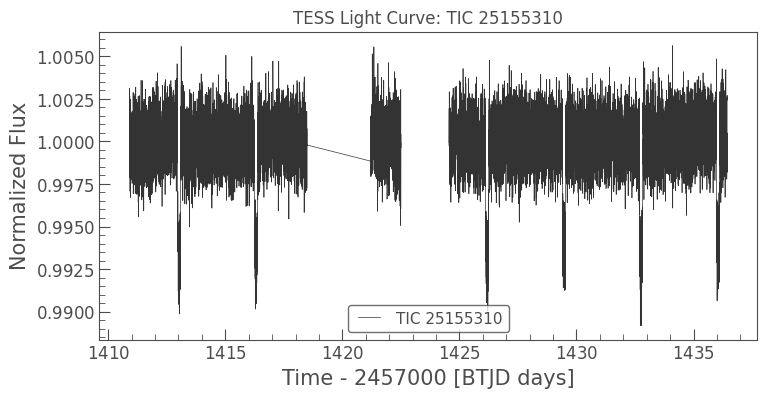

In [3]:
target = "TIC 25155310"  # ดาวแม่ของ K2-18 b
lc_file = search_lightcurvefile(target, mission="TESS").download()

lc = lc_file.PDCSAP_FLUX.normalize()  # normalize flux
lc.plot()
plt.title(f"TESS Light Curve: {target}")
plt.show()

/Users/ballth24/Documents/Dev/A World Away/.venv/lib/python3.13/site-packages/lightkurve/lightcurve.py:1062: LightkurveWarning: `epoch_time` appears to be given in JD, however the light curve time uses BTJD (i.e. JD - 2457000).
  warnings.warn(


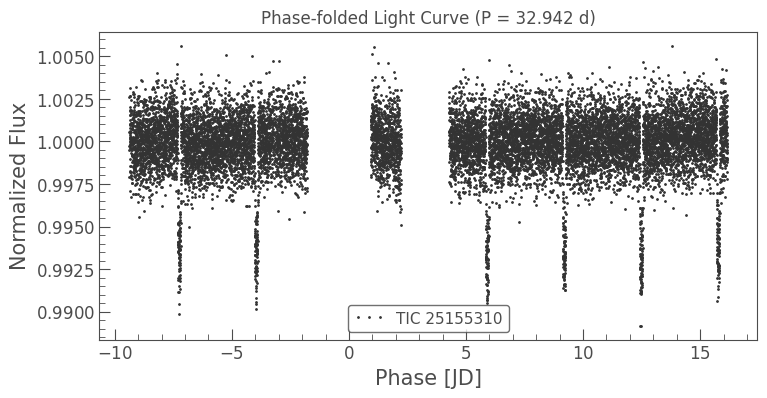

In [7]:
period = ps_table["pl_orbper"][0].value 
t0 = ps_table["pl_tranmid"][0].value  

lc_folded = lc.fold(period=period, epoch_time=t0)
lc_folded.plot(marker=".", linestyle="none")
plt.title(f"Phase-folded Light Curve (P = {period:.3f} d)")
plt.show()

In [11]:
from sklearn.ensemble import RandomForestClassifier

X = np.array([[lc_folded.flux.min(),
                lc_folded.flux.max(),
                lc_folded.flux.mean(),
                lc_folded.flux.std()]])
y = [1]  # 1 = planet signal

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X, y)  # ใช้ตัวอย่างเดียว train
y_pred = clf.predict(X)
print("Prediction:", y_pred)

Prediction: [1]
